In [1]:
import pandas as pd 
import cv2
from os import walk
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle

import os

# Getting the test and train data

In [3]:
data =pd.read_csv('Train.csv',sep=',')
data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


The first step is to take all the data from the train csv file. We load them with the tensorflow function load_img with the size 50x50. 
Next, we take all the images with no signs made with the script and add the labels to y_train. We label them 43. The goal here is to predict a lot of boxes in a picture and tell if it's a sign or not, and if it's one, directly knows wich sign it is.
We repeat the same thing for the test data. 

In [4]:
X_train=[]
length=[]
y_train=[]


for data in data.values:
    img=cv2.imread(data[7])
    if type(img)!=type(None):
        image = load_img(data[7], target_size=(50, 50))
        image = img_to_array(image)

        X_train.append(image)
        y_train.append(data[6])

    

listeFichiers = []
for (repertoire, sousRepertoires, fichiers) in walk("C:/Users/julie/Desktop/Microsoft/Projet reconnaissance panneaux/Data_Signs/Train/43"):
    listeFichiers.extend(fichiers)


for fichier in listeFichiers:
    img=cv2.imread("C:/Users/julie/Desktop/Microsoft/Projet reconnaissance panneaux/Data_Signs/Train/43/"+fichier)
    if type(img)!=type(None):
        image = load_img(("C:/Users/julie/Desktop/Microsoft/Projet reconnaissance panneaux/Data_Signs/Train/43/"+fichier), target_size=(50, 50))
        image = img_to_array(image)

        X_train.append(image)
        length.append(0)


for i in range(len(length)):
    y_train=np.append(y_train,43)



In [5]:
len(y_train)

40111

In [6]:
data = pd.read_csv('Test.csv',sep=',')
data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
X_test=[]
length=[]
y_test=[]


for data in data.values:
    img=cv2.imread(data[7])
    if type(img)!=type(None):
        image = load_img(data[7], target_size=(50, 50))
        image = img_to_array(image)

        X_test.append(image)
        y_test.append(data[6])

        

listeFichiers = []
for (repertoire, sousRepertoires, fichiers) in walk("C:/Users/julie/Desktop/Microsoft/Projet reconnaissance panneaux/Data_Signs/Train/43"):
    listeFichiers.extend(fichiers)


for fichier in listeFichiers:
    img=cv2.imread("C:/Users/julie/Desktop/Microsoft/Projet reconnaissance panneaux/Data_Signs/Train/43/"+fichier)
    if type(img)!=type(None):
        image = load_img(("C:/Users/julie/Desktop/Microsoft/Projet reconnaissance panneaux/Data_Signs/Train/43/"+fichier), target_size=(50, 50))
        image = img_to_array(image)

        X_test.append(image)
        length.append(0)


for i in range(len(length)):
    y_test=np.append(y_test,43)

Now that we have all our data gathered, we convert them to numpy array with the good shape. We scale our data to be in the range 0-1 to have a better model at the end.

In [8]:
X_train=np.array(X_train)
X_test=np.array(X_test)


In [9]:
X_train=X_train.reshape(-1,50,50,3).astype('float')/255
X_test=X_test.reshape(-1,50,50,3).astype('float')/255

## Create and training of the model

At this point, we create a cnn that we will train with 10 epochs. We finally have an accuracy of 97% on the test dataset, and a pretty good confusion matrix. TO fiish the process, we save the model to use it for inference later.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 128)         0

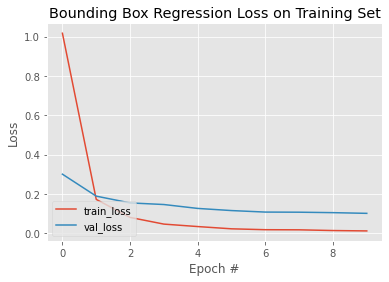

In [11]:

model = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(50,50,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(44, activation='softmax')
])


losses =  "sparse_categorical_crossentropy"

opt = Adam(lr=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"])
print(model.summary())

H  = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=True)




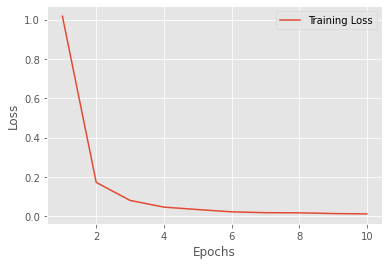

Nous avons une accuracy de : 0.9704404374815253


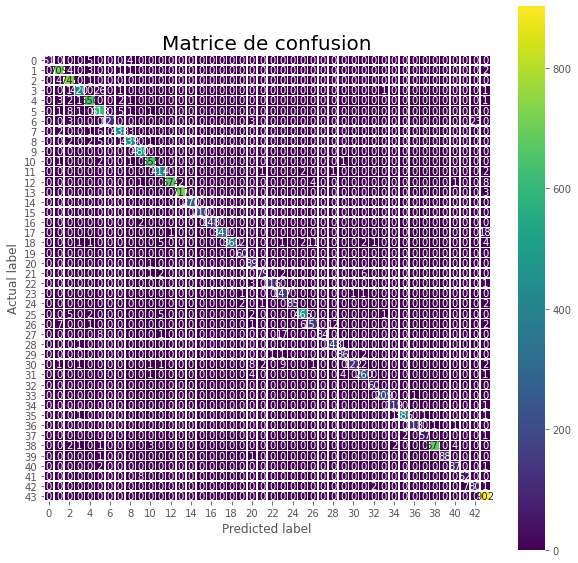

In [14]:
from sklearn import metrics
import seaborn as sns

y_pred=model.predict(X_test)
prob=[]
for pred in y_pred:
    prob.append(np.argmax(pred))
y_pred=prob  
score=metrics.accuracy_score(y_test,y_pred)

loss_values = H.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

print("Nous avons une accuracy de : {}".format(score))

cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'viridis')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion", size = 20)
plt.show()

In [15]:
model.save('signs_classification_operationel6')

INFO:tensorflow:Assets written to: signs_classification_operationel6\assets
